In [110]:
from pyesgf.search import SearchConnection
from pyesgf.logon import LogonManager
import pandas as pd
import xarray as xr
import numpy as np
from pathlib import Path
import pylab as plt
from joblib import Parallel, delayed
import operator
from typing import Union
from tqdm.auto import tqdm
from cdo import Cdo
from functools import reduce

## Log on with OpenID

In [2]:
lm = LogonManager()
lm.logoff()
lm.is_logged_on()

my_id = "aaschwanden"

OPENID = f"https://esgf-node.llnl.gov/esgf-idp/openid/{my_id}"
lm.logon_with_openid(openid=OPENID, password=None, bootstrap=True)
lm.is_logged_on()

Enter password for aaschwanden:  ········


True

## Select Experiments and Variables

In [3]:
experiments = ["lig127k", "midPliocene-eoi400"]
variables = ["pr", "tas"]

In [4]:
conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True)
ctx = conn.new_context(facets='project,experiment_id')
facets='project,experiment_family'
ctx = conn.new_context(project='CMIP6',
                       activity_id="PMIP",
                       realm="atmos",
                       table_id="Amon",
                       variable_id=variables,
                       experiment_id=experiments,
                       facets=facets)
print('Hits:', ctx.hit_count)

Hits: 148


In [16]:
def mapping(result):
    return list(map(lambda f : {'variable': f.filename.split("_")[0], 
                                'table_id': f.filename.split("_")[1],
                                'source_id': f.filename.split("_")[2],
                                'experiment_id': f.filename.split("_")[3],
                                'sub_experiment_id': f.filename.split("_")[4],
                                'filename': f.filename, 
                                'url': f.opendap_url, 
                                'size': f.size, 
                                'checksum': f.checksum, 
                                'checksum_type': f.checksum_type},
                    result))

In [17]:
n_jobs = 16
results = ctx.search()
n_files = len(results)

joblib_files = Parallel(n_jobs=n_jobs)(
    delayed(mapping)(results[i].file_context().search())
    for i in tqdm(range(n_files))
)

  0%|                                                                                                                                          | 0/148 [00:00<?, ?it/s]
-------------------------------------------------------------------------------
Warning - defaulting to search with facets=*

This behavior is kept for backward-compatibility, but ESGF indexes might not
successfully perform a distributed search when this option is used, so some
results may be missing.  For full results, it is recommended to pass a list of
facets of interest when instantiating a context object.  For example,

      ctx = conn.new_context(facets='project,experiment_id')

Only the facets that you specify will be present in the facets_counts dictionary.

This warning is displayed when a distributed search is performed while using the
facets=* default, a maximum of once per context object.  To suppress this warning,
set the environment variable ESGF_PYCLIENT_NO_FACETS_STAR_WARNING to any value
or explicitly u

In [18]:
all_files = [joblib_files[i][0] for i in range(len(joblib_files)) if len(joblib_files[i]) > 0]
all_files = sorted(all_files, key=operator.itemgetter("filename"))

## Generate a DataFrame with all files. Save to disk for later use.

In [19]:
df = pd.DataFrame.from_dict(all_files).drop_duplicates()
df.to_csv("experiments.csv")

## Read Experiment Table

In [20]:
df = pd.read_csv("experiments.csv")

In [10]:
def download(row, odir: Union[Path, str] = "pmip_raw"):
    """
    Download function
    """
    url = row["url"]
    filename = Path(row["filename"])
    if not isinstance(odir, Path):
        odir = Path(odir)
    odir.mkdir(exist_ok=True)
    m_filename = odir / filename
    try:
        ds = xr.open_dataset(url, decode_times=False, engine="netcdf4")
        if not Path(m_filename).exists():
            ds = xr.open_dataset(url, decode_times=False)
            ds["experiment_id"] = ds.attrs["experiment_id"]
            if "pr" in ds:
                ds["pr"] *= 31556925.9747
                ds["pr"]["units"] = "kg m-2 yr-1"
            print(f"Saving {m_filename}")
            ds.to_netcdf(m_filename)
    except:
        pass

In [11]:
n_files = len(df)
print(n_files)

joblib_files = Parallel(n_jobs=10)(
    delayed(download)(row)
    for _, row in tqdm(df.iterrows())
)

146



0it [00:00, ?it/s]/Users/andy/.local/lib/python3.12/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(

20it [00:03,  6.44it/s]/Users/andy/.local/lib/python3.12/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 901-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0901-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/andy/.local/lib/python3.12/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/andy/.local/lib/python3.12/site-packages/xarray/coding/times.py:167: Serializati

Saving pmip_raw/pr_Amon_HadGEM3-GC31-LL_midPliocene-eoi400_r1i1p1f1_gn_233401-239312.nc
Saving pmip_raw/pr_Amon_GISS-E2-1-G_lig127k_r1i1p1f1_gn_290001-294912.nc
Saving pmip_raw/pr_Amon_HadGEM3-GC31-LL_lig127k_r1i1p1f1_gn_185001-204912.nc



60it [01:36,  2.76s/it]

Saving pmip_raw/pr_Amon_CNRM-CM6-1_lig127k_r1i1p1f2_gr_185001-209912.nc
Saving pmip_raw/pr_Amon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gr_185001-204912.nc
Saving pmip_raw/pr_Amon_GISS-E2-1-G_lig127k_r1i1p1f1_gn_290001-294912.nc
Saving pmip_raw/pr_Amon_GISS-E2-1-G_midPliocene-eoi400_r1i1p1f1_gn_305101-310012.nc
Saving pmip_raw/pr_Amon_HadGEM3-GC31-LL_lig127k_r1i1p1f1_gn_185001-204912.nc
Saving pmip_raw/pr_Amon_INM-CM4-8_lig127k_r1i1p1f1_gr1_190001-199912.nc
Saving pmip_raw/pr_Amon_INM-CM4-8_lig127k_r1i1p1f1_gr1_190001-199912.nc



70it [02:13,  3.03s/it]

Saving pmip_raw/pr_Amon_CNRM-CM6-1_lig127k_r1i1p1f2_gr_185001-209912.nc



80it [02:19,  2.28s/it]/Users/andy/.local/lib/python3.12/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 901-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0901-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/andy/.local/lib/python3.12/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 901-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0901-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/andy/.local/lib/python3.12/site-packages/xarray/coding/times.py:167: SerializationWarning: Am

Saving pmip_raw/pr_Amon_CNRM-CM6-1_lig127k_r1i1p1f2_gr_185001-209912.nc


/Users/andy/.local/lib/python3.12/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 901-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0901-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)

90it [02:26,  1.78s/it]/Users/andy/.local/lib/python3.12/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/andy/.local/lib/python3.12/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/andy/.local/lib/python3.12/site-packages/xarray/conventions.py:448: SerializationWarning: variabl

Saving pmip_raw/pr_Amon_MIROC-ES2L_lig127k_r1i1p1f2_gn_330001-339912.nc
Saving pmip_raw/tas_Amon_CESM2_midPliocene-eoi400_r1i1p1f1_gn_000101-005012.nc



100it [02:40,  1.68s/it]

Saving pmip_raw/tas_Amon_CESM2_midPliocene-eoi400_r1i1p1f1_gn_000101-005012.nc



110it [02:57,  1.69s/it]

Saving pmip_raw/pr_Amon_NorESM1-F_lig127k_r1i1p1f1_gn_150101-151012.nc
Saving pmip_raw/pr_Amon_NorESM1-F_midPliocene-eoi400_r1i1p1f1_gn_230101-231012.nc
Saving pmip_raw/pr_Amon_NorESM2-LM_lig127k_r1i1p1f1_gn_210101-211012.nc
Saving pmip_raw/tas_Amon_AWI-ESM-1-1-LR_lig127k_r1i1p1f1_gn_300101-300512.nc
Saving pmip_raw/tas_Amon_CESM2_lig127k_r1i1p1f1_gn_000101-005012.nc
Saving pmip_raw/pr_Amon_INM-CM4-8_lig127k_r1i1p1f1_gr1_190001-199912.nc
Saving pmip_raw/pr_Amon_IPSL-CM6A-LR_lig127k_r1i1p1f1_gr_185001-194912.nc
Saving pmip_raw/pr_Amon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gr_185001-204912.nc
Saving pmip_raw/pr_Amon_CNRM-CM6-1_lig127k_r1i1p1f2_gr_185001-209912.nc



120it [03:08,  1.50s/it]
130it [03:32,  1.79s/it]

Saving pmip_raw/pr_Amon_NESM3_lig127k_r1i1p1f1_gn_160001-169912.nc
Saving pmip_raw/pr_Amon_NorESM1-F_lig127k_r1i1p1f1_gn_150101-151012.nc
Saving pmip_raw/tas_Amon_ACCESS-ESM1-5_lig127k_r1i1p1f1_gn_090101-110012.nc
Saving pmip_raw/tas_Amon_EC-Earth3-LR_lig127k_r1i1p1f1_gr_224001-224012.nc
Saving pmip_raw/tas_Amon_GISS-E2-1-G_midPliocene-eoi400_r1i1p1f1_gn_305101-310012.nc
Saving pmip_raw/tas_Amon_HadGEM3-GC31-LL_lig127k_r1i1p1f1_gn_185001-204912.nc



146it [03:40,  1.51s/it]

Saving pmip_raw/tas_Amon_GISS-E2-1-G_lig127k_r1i1p1f1_gn_290001-294912.nc
Saving pmip_raw/tas_Amon_HadGEM3-GC31-LL_midPliocene-eoi400_r1i1p1f1_gn_233401-239312.nc


Saving pmip_raw/pr_Amon_NorESM2-LM_lig127k_r1i1p1f1_gn_210101-211012.nc
Saving pmip_raw/tas_Amon_ACCESS-ESM1-5_lig127k_r1i1p1f1_gn_090101-110012.nc
Saving pmip_raw/pr_Amon_MIROC-ES2L_lig127k_r1i1p1f2_gn_330001-339912.nc
Saving pmip_raw/tas_Amon_CNRM-CM6-1_lig127k_r1i1p1f2_gr_185001-209912.nc
Saving pmip_raw/tas_Amon_IPSL-CM6A-LR_lig127k_r1i1p1f1_gr_185001-194912.nc
Saving pmip_raw/tas_Amon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gr_185001-204912.nc
Saving pmip_raw/tas_Amon_FGOALS-g3_lig127k_r1i1p1f1_gn_075001-075912.nc
Saving pmip_raw/tas_Amon_HadGEM3-GC31-LL_lig127k_r1i1p1f1_gn_185001-204912.nc
Saving pmip_raw/pr_Amon_HadGEM3-GC31-LL_lig127k_r1i1p1f1_gn_185001-204912.nc
Saving pmip_raw/pr_Amon_IPSL-CM6A-LR_midPliocene-eoi400_r1i1p1f1_gr_185001-204912.nc
Saving pmip_raw/tas_Amon_INM-CM4-8_lig127k_r1i1p1f1_gr1_190001-199912.nc
Saving pmip_raw/tas_Amon_NorESM1-F_lig127k_r1i1p1f1_gn_150101-151012.nc
Saving pmip_raw/tas_Amon_NorESM2-LM_lig127k_r1i1p1f1_gn_210101-211012.nc
Saving pmip_raw/

In [14]:
cdo = Cdo()

## Merge time and remap to common grid to allow computing stats

In [85]:
def check_files(files):
    if f.exists():
        return f.as_posix()

n_jobs = 8
idir: Union[Path, str] = Path("pmip_raw")
odir: Union[Path, str] = Path("pmip_processed")
odir.mkdir(exist_ok=True)
processed_df = []
for (m_var, m_exp, m_source), gcm_df in df.groupby(by=["variable", "experiment_id", "source_id"]):
    ifiles = [idir / Path(f) for f in gcm_df["filename"]]
    ofile = odir / Path(f"{m_var}_Amon_{m_source}_{m_exp}.nc")
    try:
        cdo.remapycon("r360x180 -timmean -mergetime", input=[check_file(f) for f in ifiles], output=ofile.as_posix(),  options =f"-O -f nc -z zip_3 -P {n_jobs}")
        processed_df.append(pd.DataFrame.from_dict({"variable_id": [m_var], "experiment_id": [m_exp], "source_id": [m_source], "filename": ofile}))
    except:
        pass

Error in calling operator remapycon with:
>>> cdo -O -s -O -f nc -z zip_3 -P 8 -remapycon,r360x180 -timmean -mergetime pmip_raw/tas_Amon_FGOALS-f3-L_lig127k_r1i1p1f1_gr_070001-119912.nc pmip_raw/tas_Amon_FGOALS-f3-L_lig127k_r1i1p1f1_gr_070001-119912.nc pmip_raw/tas_Amon_FGOALS-f3-L_lig127k_r1i1p1f1_gr_070001-119912.nc pmip_raw/tas_Amon_FGOALS-f3-L_lig127k_r1i1p1f1_gr_070001-119912.nc pmip_processed/tas_Amon_FGOALS-f3-L_lig127k.nc<<<
STDOUT:
STDERR:cdi  warning (cdfInqContents): No arrays found!
cdo(2) mergetime: Open failed on >pmip_raw/tas_Amon_FGOALS-f3-L_lig127k_r1i1p1f1_gr_070001-119912.nc<
                  Unsupported file structure



In [86]:
proccessed_df = pd.concat(processed_df).reset_index(drop=True)

In [142]:
def preprocess(ds):
    ds["experiment_id"] = ds.attrs["experiment_id"]
    source_id = ds.attrs["source_id"]
    ds = ds.assign_coords({"source_id": source_id}).drop("height", errors="ignore")
    return ds.sel(lat=slice(60, 85), lon=slice(285, 350))

In [143]:
intersection  = proccessed_df.groupby(by=["variable_id", "experiment_id"])["source_id"].unique()
intersection_gcms = reduce(lambda  left,right: list(set(left).intersection(set(right))), intersection)
intersection_df = proccessed_df[proccessed_df["source_id"].isin(intersection_gcms)]

/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_72091/2761934652.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.assign_coords({"source_id": source_id}).drop("height", errors="ignore")
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_72091/2761934652.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.assign_coords({"source_id": source_id}).drop("height", errors="ignore")
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_72091/2761934652.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.assign_coords({"source_id": source_id}).drop("height", errors="ignore")
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_72091/2761934652.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.assign_coords({"source_id": source_id}).drop("height", errors="ignore")


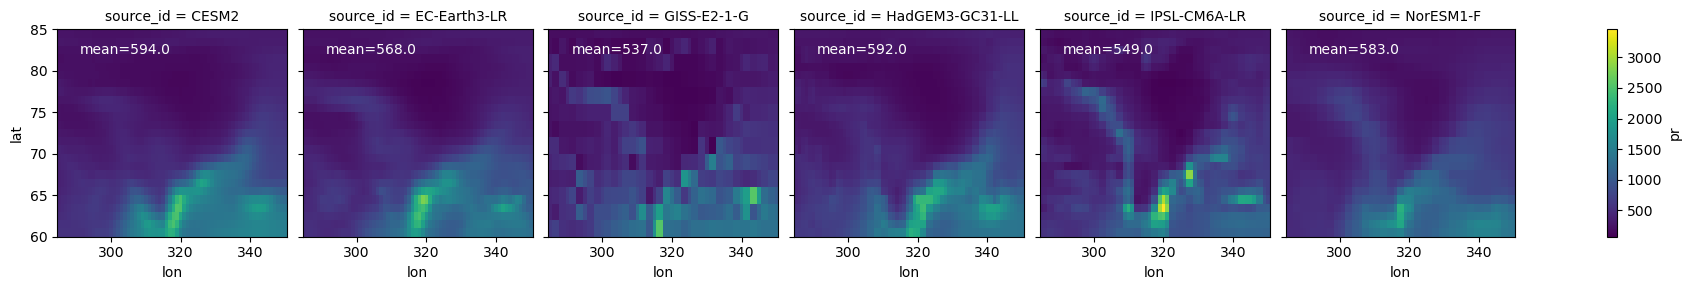

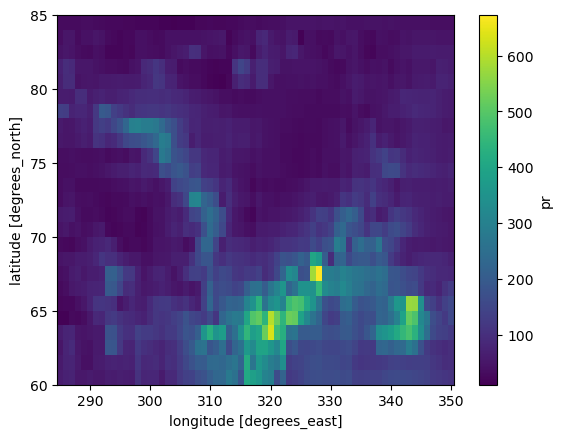

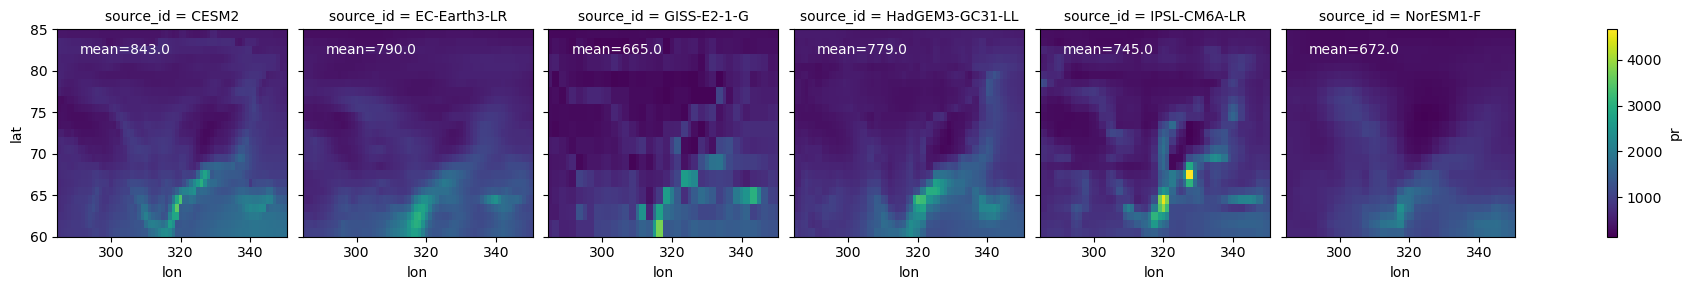

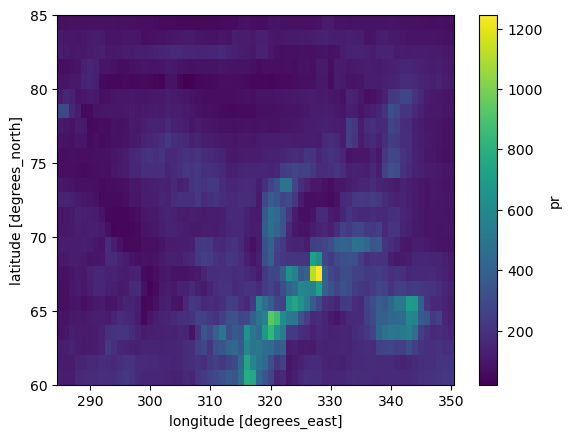

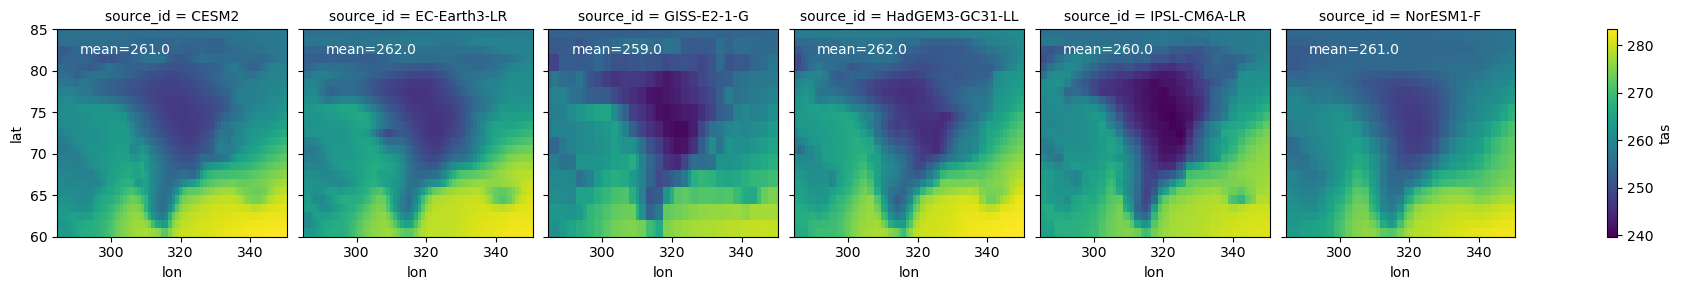

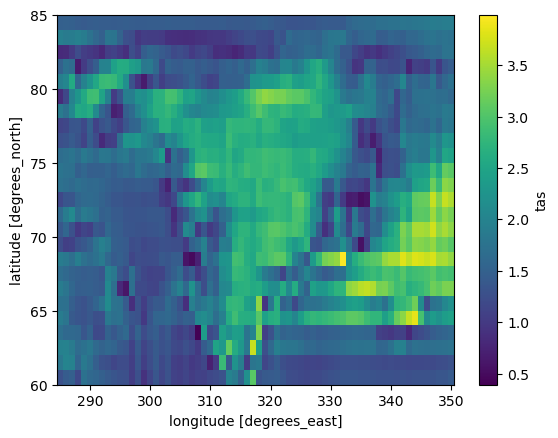

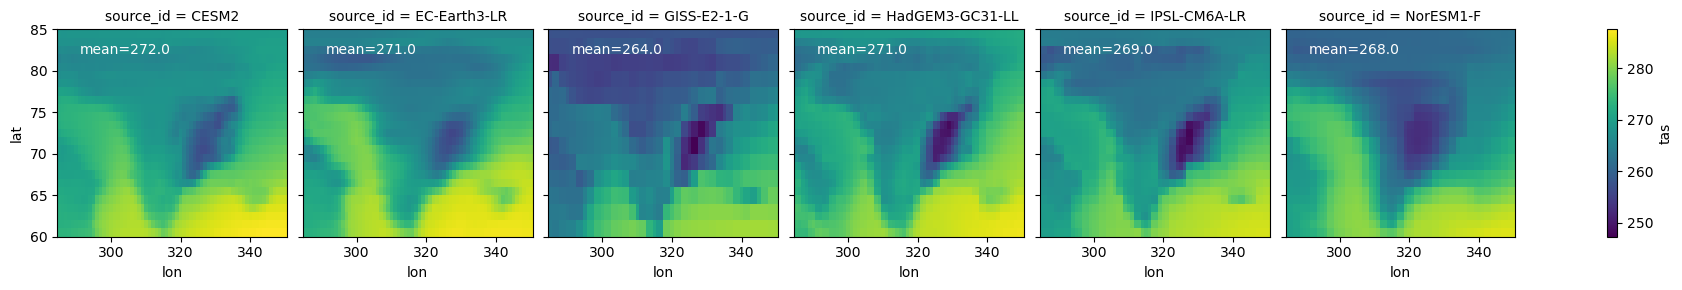

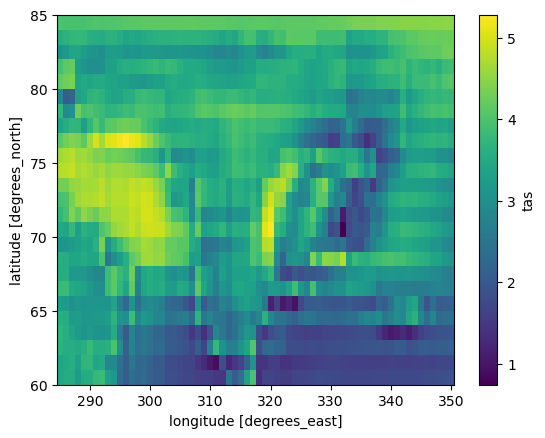

In [152]:
for (m_var, m_exp), m_df in intersection_df.groupby(by=["variable_id", "experiment_id"]):
    p = m_df["filename"]
    ds = xr.open_mfdataset(p, parallel=True, concat_dim="source_id", combine="nested",
                           data_vars='minimal', coords='minimal', compat='override', preprocess=preprocess, decode_times=False)
    f = ds[m_var].mean(dim="time").plot(col="source_id", col_wrap=6)
    mean = ds[m_var].mean(dim=["time", "lat", "lon"]).to_dataframe()
    variance = ds[m_var].std(dim=["time", "source_id"])
    [f.axs.ravel()[source[0]].text(0.1, 0.9, f"""mean={np.round(source[1][-1].to_numpy()[0])}""", color="w", horizontalalignment='left',
     verticalalignment='center', transform=f.axs.ravel()[source[0]].transAxes) for source in enumerate(mean.iterrows())]
    f.fig.savefig(f"{m_var}_{m_exp}.pdf")
    fig, ax = plt.subplots(1, 1)
    f_var = variance.plot(ax=ax)



In [ ]:
plt.cle